# Cepheid light curve

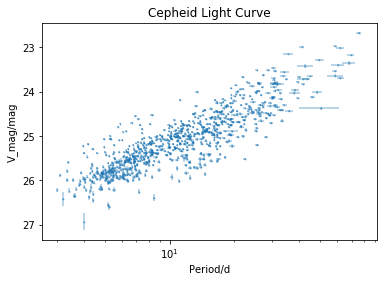

In [1]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Use pandas library to import data as dataframe
# Here some modifications is operated on the raw file
# Change all separator to "  "(double whitespace)
# Attention! header need to be set as 12 for removing NaN rows
data = pd.read_table("data/week3_cepheid.dat", sep="  ", 
                     header=12, engine="python")

fig, ax = plt.subplots()
ax.errorbar(data["Per(d)"], data["V_mag(mag)"], 
            xerr=data["e_Per(d)"], yerr=data["e_Vmag(mag)"],
            marker='o', markersize=1, alpha=.4, linestyle=" ")
ax.set_xscale("log")
ax.set_yscale("linear")
ax.set_xlabel("Period/d")
ax.set_ylabel("V_mag/mag")
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_title("Cepheid Light Curve");

There may exist a linear relation between log(period) and magnitude of a cepheid. 
Suppose,

\begin{equation}
    V_{mag} = k \cdot \log(P) + V_0
\end{equation}

Fit result: V_mag = -0.9176 * log(Period) + 27.2881


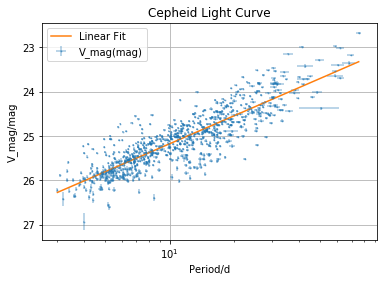

In [85]:
p = np.polyfit(np.log(data["Per(d)"]), data["V_mag(mag)"], 1)
p = np.poly1d(p)

fit_period = np.linspace(data["Per(d)"].min(), data["Per(d)"].max())
fit_mag = p(np.log(fit_period))

fig, ax = plt.subplots()
ax.errorbar(data["Per(d)"], data["V_mag(mag)"], 
            xerr=data["e_Per(d)"], yerr=data["e_Vmag(mag)"],
            marker='o', markersize=1, alpha=.4, linestyle=" ")
ax.plot(fit_period, fit_mag, label="Linear Fit")
ax.set_xscale("log")
ax.set_yscale("linear")
ax.set_xlabel("Period/d")
ax.set_ylabel("V_mag/mag")
ax.set_ylim(ax.get_ylim()[::-1])
ax.legend()
ax.set_title("Cepheid Light Curve")
ax.grid(True)

print(f"Fit result: V_mag = {p[1]:.4f} * log(Period) + {p[0]:.4f}")

# Star image and colorbar

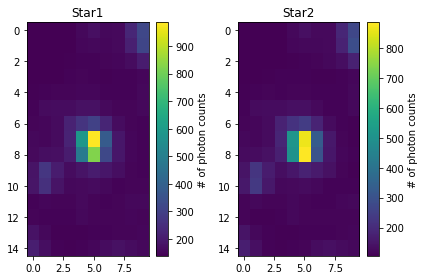

In [82]:
star1 = np.genfromtxt("data/week3_star1.dat")
star2 = np.genfromtxt("data/week3_star2.dat")
stars = [star1, star2]

fig, axs = plt.subplots(nrows=1, ncols=2)
for i, ax in enumerate(axs):
    im = ax.imshow(stars[i])
    ax.set_aspect('auto')
    ax.set_title(f"Star{i+1}")
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("# of photon counts")
fig.tight_layout()
fig.savefig("week3_starsimg.eps")

# Silicon (111) STM

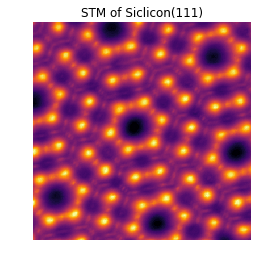

In [9]:
silicon = np.genfromtxt("data/week3_stm.dat.txt")

plt.imshow(silicon, cmap="inferno")
plt.title("STM of Siclicon(111)")
plt.axis("off")
plt.savefig("silicon.STM.pdf")

# Prime density relation

In [11]:
from functools import lru_cache

# For optimizing iteration time, 
# use lru_cache to store previous results
@lru_cache(maxsize=128)
def prime_filter(n):
    # return a list containing all prime numbers between 2 and n
    prime_list = [2]
    # Define prime_filter(2)
    if n <= 2:
        return [2]
    # Set start point to 3
    for j in range(3, n+1):
        # Add j to the end of prime_list as a potential valid element 
        prime_list.append(j)
        # Use iteration to check division between 2 and n^0.5
        for i in prime_filter(int(j**0.5)):
            if j % i == 0:
                # j is not a prime number, just remove it
                prime_list.remove(j)
                break
                
    return prime_list


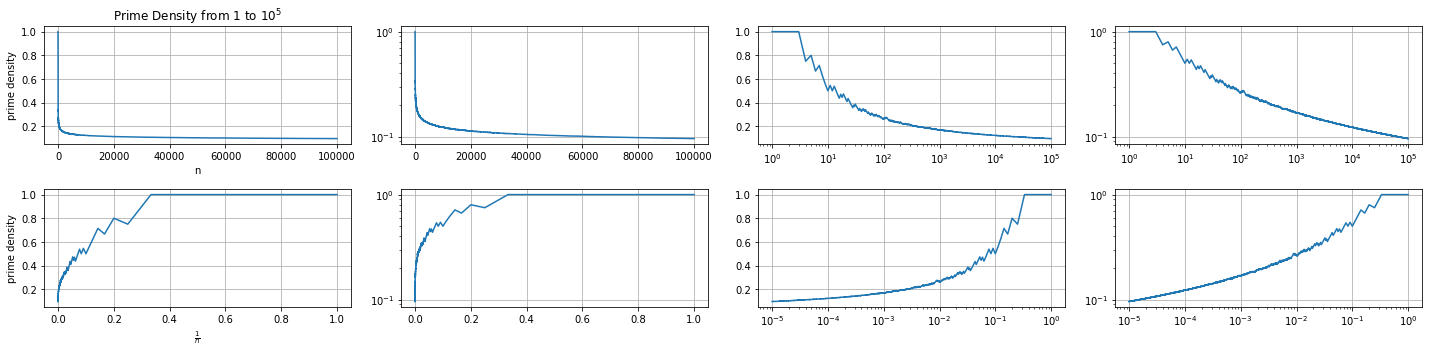

In [12]:
from itertools import product

primes = np.array(prime_filter(10**5))
# Insert 1 as a prime number to the head
primes = np.insert(primes, 0, 1)

# Calculate prime density for every number from 1 to 1.e5
numbers = np.arange(1, 10**5+1)
prime_density = [len(primes[primes <= i]) / i for i in numbers] 

# Use product to generate list of 4 scale tuples
scales = list(product(["linear", "log"], repeat=2))
# In order to compare relation in different axis scales
# Create a 2x4 subplots
# First row shows n-density. Second row shows 1/n-density
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 5))
# Plotting
for j, row_axs in enumerate(axs):
    # Plot n or 1/n according to row index j
    # Convert power to float to avoid ValueError
    power = float((-1)**j)
    for i, ax in enumerate(row_axs):
        ax.plot(numbers**power, prime_density)
        xscale, yscale = scales[i]
        ax.set_xscale(xscale)
        ax.set_yscale(yscale)
        ax.grid(True)

axs[0, 0].set_xlabel("n")
axs[0, 0].set_ylabel("prime density")
axs[0, 0].set_title("Prime Density from 1 to $10^5$")
axs[1, 0].set_xlabel(r"$\frac{1}{n}$")
axs[1, 0].set_ylabel("prime density")
fig.tight_layout()

Suppose 
\begin{equation}
    \log \left(\textbf{prime density} \right) = \frac{a}{\log n + b} + c
\end{equation}

Fit result: Prime Density = 34.2169/(log(n)+7.5691) + -4.1369


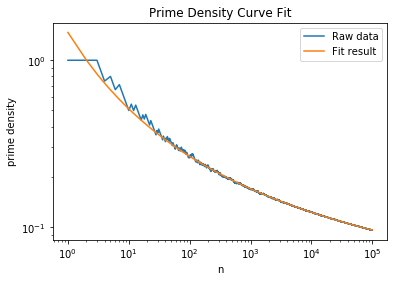

In [113]:
from scipy.optimize import curve_fit


def prime_density_fit(n, a, b, c):
    return np.e**(a / (np.log(n) + b) + c)


# Fit data from 100 to remove some irregular samples
popts, pcov = curve_fit(prime_density_fit, numbers[100:], prime_density[100:])
plt.plot(numbers, prime_density, 
         numbers, prime_density_fit(numbers, *popts))
plt.legend(["Raw data", "Fit result"])
plt.xscale("log")
plt.yscale("log")
plt.xlabel("n")
plt.ylabel("prime density")
plt.title("Prime Density Curve Fit")

print("Fit result: "
      f"Prime Density = {popts[0]:.4f}/(log(n)+{popts[1]:.4f}) + {popts[2]:.4f}")